<a href="https://colab.research.google.com/github/new-divos/ttirep/blob/develop/p2e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ преобразования потока с распределением Парето в поток с экспоненциальным распределением

In [0]:
import sqlite3

import numpy as np
import pandas as pd

from scipy import stats

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Получить идентификаторы баз данных

In [0]:
folder_id = 'root'
for node_name in ('Colab Notebooks', 'Data', 'Input', 'Networking'):
  node_list = drive.ListFile({
      'q': f"'{folder_id}' in parents and trashed=false"
      }).GetList()
  for node in node_list:
    if node['title'] == node_name:
      folder_id = node['id']

p2ee_id, p2em_id = None, None
node_list = drive.ListFile({
    'q': f"'{folder_id}' in parents and trashed=false"
}).GetList()
for node in node_list:
  node_name = node['title']
  if node_name == 'P2EE.db':
    p2ee_id = node['id']
  elif node_name == 'P2EM.db':
    p2em_id = node['id']

Удалить сгенерированный отчет

In [0]:
folder_id = 'root'
for node_name in ('Colab Notebooks', 'Data', 'Output', 'Networking'):
  node_list = drive.ListFile({
      'q': f"'{folder_id}' in parents and trashed=false"
      }).GetList()
  for node in node_list:
    if node['title'] == node_name:
      folder_id = node['id']

node_list = drive.ListFile({
    'q': f"'{folder_id}' in parents and trashed=false"
}).GetList()
for node in node_list:
  if node['title'] == 'p2e.xlsx':
    p2e_id = node['id']
    p2e_file = drive.CreateFile({'id': p2e_id})
    p2e_file.Delete()

Задать количество сгенерированных пакетов

In [0]:
population_size = 1024

Вспомогательная функция подготовки фрейма данных для последующего их отображения

In [0]:
def get_compact_table(df: pd.DataFrame) -> pd.DataFrame:
  index = np.arange(0., 0.1, 0.01)
  columns = np.arange(0.5, 1.0, 0.1) 
  data = np.zeros((index.shape[0], columns.shape[0]))

  for row in df.iterrows():
    h = round(row[0] * 100)
    row_idx, col_idx = h % 10, (h // 10) - 5
    data[row_idx, col_idx] = row[1].values[0]

  return pd.DataFrame(data=data, 
                      index=index, 
                      columns=columns, 
                      dtype=np.float32)

## Загрузка данных

### Преобразование потока из распределение Парето в экспоненциальное распределение с использованием математического ожидания

Выполним загрузку базы данных

In [0]:
p2ee_db = drive.CreateFile({'id': p2ee_id})
p2ee_db.GetContentFile('P2EE.db')

In [0]:
p2ee_conn = sqlite3.connect('P2EE.db')

Получить идентификаторы паттернов

In [9]:
patterns = dict()

for row in p2ee_conn.execute("SELECT * FROM pattern;").fetchall():
  patterns[row[1]] = row[0]

print(patterns)

{'Pareto': 1, 'Weibull': 2, 'Exponent': 3, 'Uniform': 4}


Получить идентификаторы методов трансформации

In [10]:
methods = dict()

for row in p2ee_conn.execute("SELECT * FROM method;").fetchall():
  methods[row[1]] = row[0]

print(methods)

{'Expectation': 1, 'Median': 2}


Получить данные о количестве пакетов в очереди в случае использования бесконечной очереди

In [11]:
p2ee_df = pd.read_sql_query(
    """
    SELECT pareto.hurst, experiment.enqueued FROM model 
    INNER JOIN pareto ON model.id = pareto.model_id
    INNER JOIN experiment ON model.id = experiment.model_id
    WHERE population_size={} AND 
      queue_size=0 AND 
      arrivals_pattern_id={} AND
      service_pattern_id={} AND
      method_id={} AND
      number_of_servers=1;
    """.format(population_size, 
               patterns['Pareto'], patterns['Exponent'], 
               methods['Expectation']),
    p2ee_conn
)

p2ee_df.head()

,hurst,enqueued
0,0.5,43
1,0.5,103
2,0.5,66
3,0.5,45
4,0.5,43


In [0]:
p2ee_conn.close()

Получить количество испытаний

In [13]:
p2ee_df.shape

(4887, 2)

Отобразить облако точек

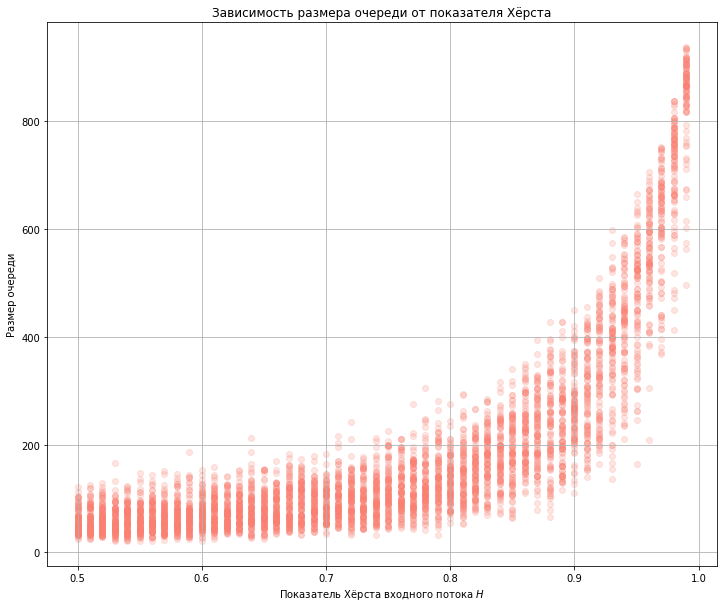

In [14]:
_, ax = plt.subplots(figsize=(12, 10))

ax.scatter(p2ee_df.hurst, p2ee_df.enqueued, c='salmon', alpha=0.2)

ax.set_title("Зависимость размера очереди от показателя Хёрста")
ax.set_xlabel("Показатель Хёрста входного потока $H$")
ax.set_ylabel("Размер очереди")

ax.grid(True)

plt.show();

Сгруппировать данные по показателю Херста

In [0]:
p2ee_grouped = p2ee_df.groupby('hurst')

Отобразить box-plot по заданным группам

In [0]:
hurst_set = set()
enqueued = list()

for group in p2ee_grouped:
  hurst_set.add(group[0])
  enqueued.append(group[1].enqueued.values)

hurst = list(hurst_set)
hurst.sort()

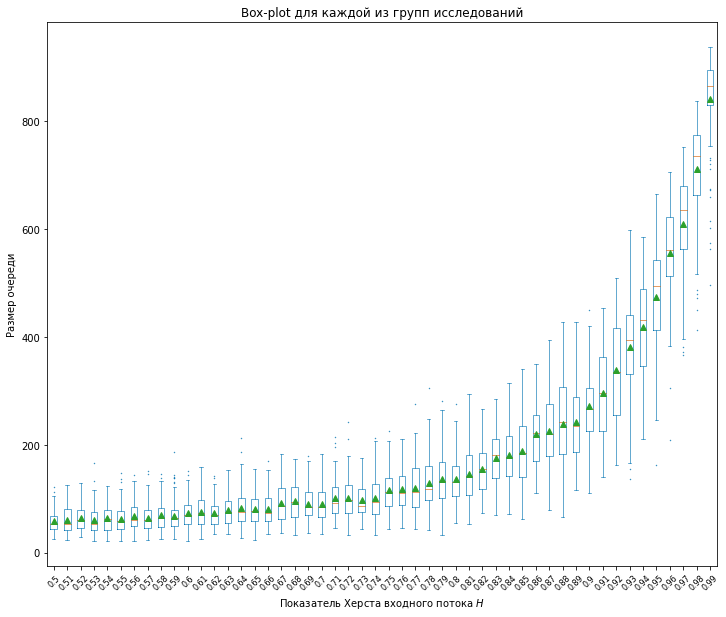

In [17]:
_, ax = plt.subplots(figsize=(12, 10))

ax.boxplot(enqueued, 
           showmeans=True,
           boxprops=dict(color='#0072b2', 
                         linewidth=0.6),
           flierprops=dict(marker='.', 
                           markerfacecolor='#0072b2', 
                           markeredgecolor='#0072b2', 
                           markersize=0.8),
           whiskerprops=dict(linestyle='-', 
                             color='#0072b2', 
                             linewidth=0.6),
           capprops=dict(color='#0072b2', 
                         linewidth=0.6),
           medianprops=dict(linewidth=0.6, 
                            color='#d55e00'))


ax.set_title("Box-plot для каждой из групп исследований")
ax.set_xlabel("Показатель Херста входного потока $H$")
ax.set_ylabel("Размер очереди")

xtickNames = plt.setp(ax, xticklabels=hurst)
plt.setp(xtickNames, rotation=45, fontsize=8)

plt.show();

### Преобразование потока из распределение Парето в экспоненциальное распределение с использованием математического ожидания

In [0]:
p2em_db = drive.CreateFile({'id': p2em_id})
p2em_db.GetContentFile('P2EM.db')

In [0]:
p2em_conn = sqlite3.connect('P2EM.db')

Получить данные о количестве пакетов в очереди в случае использования бесконечной очереди

In [20]:
p2em_df = pd.read_sql_query(
    """
    SELECT pareto.hurst, experiment.enqueued FROM model 
    INNER JOIN pareto ON model.id = pareto.model_id
    INNER JOIN experiment ON model.id = experiment.model_id
    WHERE population_size={} AND 
      queue_size=0 AND 
      arrivals_pattern_id={} AND
      service_pattern_id={} AND
      method_id={} AND
      number_of_servers=1;
    """.format(population_size, 
               patterns['Pareto'], patterns['Exponent'], 
               methods['Median']),
    p2em_conn
)

p2em_df.head()

,hurst,enqueued
0,0.5,35
1,0.5,133
2,0.5,76
3,0.5,56
4,0.5,53


In [0]:
p2em_conn.close()

Получить количество испытаний

In [22]:
p2em_df.shape

(4869, 2)

Отобразить облако точек

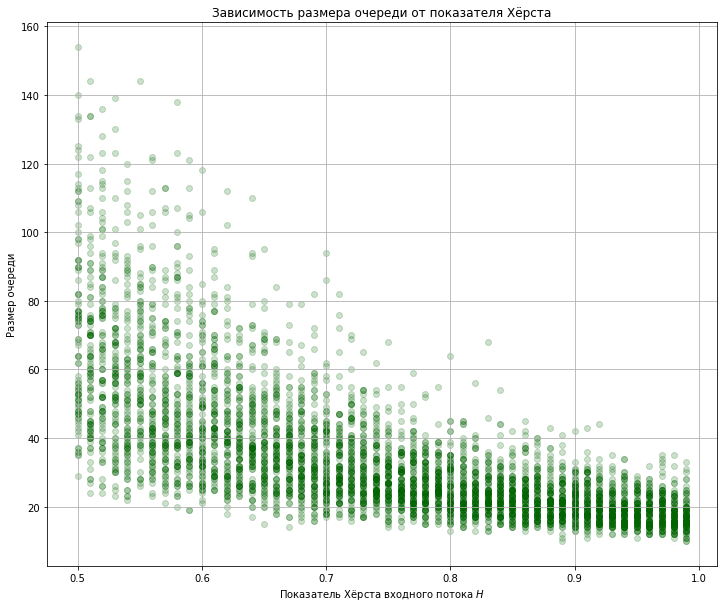

In [23]:
_, ax = plt.subplots(figsize=(12, 10))

ax.scatter(p2em_df.hurst, p2em_df.enqueued, c='darkgreen', alpha=0.2)

ax.set_title("Зависимость размера очереди от показателя Хёрста")
ax.set_xlabel("Показатель Хёрста входного потока $H$")
ax.set_ylabel("Размер очереди")

ax.grid(True)

plt.show();

Сгруппировать данные по показателю Херста

In [0]:
p2em_grouped = p2em_df.groupby('hurst')

Отобразить box-plot по заданным группам

In [0]:
hurst_set = set()
enqueued = list()

for group in p2em_grouped:
  hurst_set.add(group[0])
  enqueued.append(group[1].enqueued.values)

hurst = list(hurst_set)
hurst.sort()

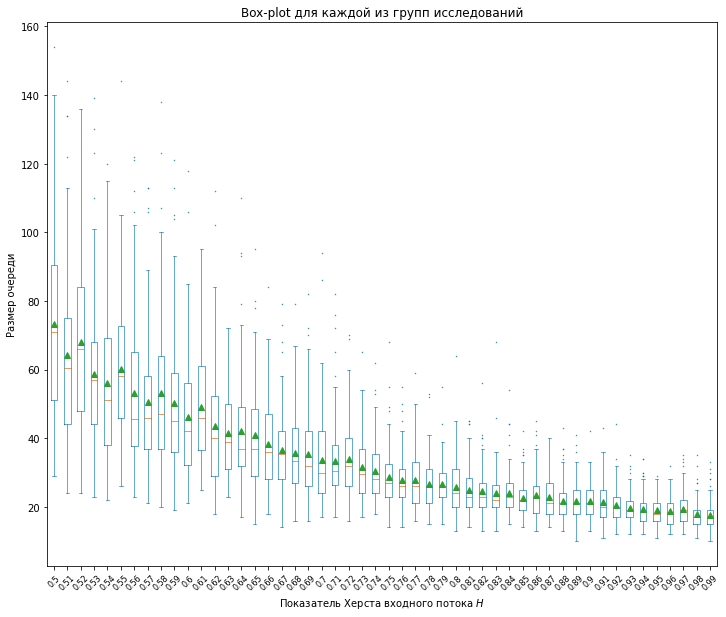

In [26]:
_, ax = plt.subplots(figsize=(12, 10))

ax.boxplot(enqueued, 
           showmeans=True,
           boxprops=dict(color='#0072b2', 
                         linewidth=0.6),
           flierprops=dict(marker='.', 
                           markerfacecolor='#0072b2', 
                           markeredgecolor='#0072b2', 
                           markersize=0.8),
           whiskerprops=dict(linestyle='-', 
                             color='#0072b2', 
                             linewidth=0.6),
           capprops=dict(color='#0072b2', 
                         linewidth=0.6),
           medianprops=dict(linewidth=0.6, 
                            color='#d55e00'))


ax.set_title("Box-plot для каждой из групп исследований")
ax.set_xlabel("Показатель Херста входного потока $H$")
ax.set_ylabel("Размер очереди")

xtickNames = plt.setp(ax, xticklabels=hurst)
plt.setp(xtickNames, rotation=45, fontsize=8)

plt.show();

## Статистические характеристики размера очереди

### Математическое ожидание 

#### Преобразование с использованием математического ожидания

Получить математическое ожидание размера очереди

In [0]:
t = p2ee_grouped.mean()

Создать сводную таблицу для преобразования с использованием математического ожидания

In [0]:
p2ee_stats = t.copy()

In [0]:
p2ee_stats.set_axis(['mean'], axis='columns', inplace=True)

Отобразить сведения о математическом ожидании в таблице

In [30]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,58.435642,72.714287,89.281250,135.408157,271.353546
0.01,60.380001,75.693878,100.104164,144.855667,296.140015
0.02,63.585857,73.371132,100.214287,154.639175,337.626251
0.03,60.061855,78.244896,97.360825,174.402069,380.814423
0.04,63.393940,82.354164,101.744896,180.193878,418.416656
0.05,62.696968,79.762886,115.551018,187.989899,474.197906
0.06,67.030304,80.969696,117.824745,219.484848,555.375000
0.07,64.234695,91.291664,120.346939,224.918365,609.093750
0.08,68.663269,95.222221,128.867340,239.000000,710.959167
0.09,68.540817,89.915787,136.424240,241.082474,840.604187


#### Преобразование с использованием медианы

Получить математическое ожидание размера очереди

In [0]:
t = p2em_grouped.mean()

Создать сводную таблицу для преобразования с использованием математического ожидания

In [0]:
p2em_stats = t.copy()

In [0]:
p2em_stats.set_axis(['mean'], axis='columns', inplace=True)

Отобразить сведения о математическом ожидании в таблице

In [34]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,73.385414,46.326530,33.757576,25.747475,21.629999
0.01,64.208336,49.234695,33.285713,24.787878,21.320000
0.02,67.927086,43.562500,33.835052,24.510870,20.561224
0.03,58.631580,41.536842,31.687500,23.919191,19.591837
0.04,56.187500,42.082474,30.593750,24.071428,19.270000
0.05,60.053192,40.852631,28.778948,22.714285,18.979591
0.06,53.083332,38.402061,27.686869,23.357143,18.709999
0.07,50.599998,36.622448,27.775511,22.919191,19.438776
0.08,53.136841,35.765305,26.721649,21.659794,17.808081
0.09,50.257732,35.320000,26.731958,21.606060,17.530001


### Среднеквадратическое отклонение

#### Преобразование с использованием математического ожидания

Получить среднеквадратическое отклонение размера очереди

In [0]:
t = p2ee_grouped.std()

Добавть сведения о среднеквадратическом отклонении в сводную таблицу

In [0]:
p2ee_stats['std'] = t['enqueued']

Отобразить сведения о среднеквадратическом отклонении в таблице

In [37]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,21.387573,27.211277,30.101828,42.897827,69.436844
0.01,23.602251,29.059629,36.715256,52.985844,82.676323
0.02,23.618139,25.839779,37.906898,45.631035,89.660080
0.03,25.399645,27.859760,34.750057,52.987156,96.452423
0.04,24.669579,35.300507,38.039673,54.207439,93.817032
0.05,25.248341,31.367371,43.212524,62.102531,103.984978
0.06,25.819410,28.619408,41.541145,58.651749,88.416862
0.07,25.477623,36.182262,43.590904,66.047577,100.336807
0.08,27.068048,34.750584,48.592274,84.276909,90.908806
0.09,29.629732,30.608253,50.925934,75.311531,87.660530


#### Преобразование с использованием медианы

Получить среднеквадратическое отклонение размера очереди

In [0]:
t = p2em_grouped.std()

Добавть сведения о среднеквадратическом отклонении в сводную таблицу

In [0]:
p2em_stats['std'] = t['enqueued']

Отобразить сведения о среднеквадратическом отклонении в таблице

In [40]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,27.832344,18.380163,13.406586,8.081654,5.066537
0.01,24.464762,17.122843,11.775390,7.373799,5.789018
0.02,25.519958,17.831263,11.289450,6.982702,5.207184
0.03,22.283022,12.657359,10.069561,7.053262,4.350226
0.04,23.403694,16.634346,8.922565,6.724704,4.861423
0.05,19.917231,15.550856,8.863238,5.464034,3.994789
0.06,22.145294,12.953169,7.383996,6.663100,4.288333
0.07,20.257071,11.491382,8.347517,6.125685,4.903326
0.08,23.686161,12.074341,7.342431,5.625253,4.270632
0.09,20.434998,12.928616,6.425074,5.605788,4.420921


### Медиана

#### Преобразование с использованием математического ожидания

Получить медиану размера очереди

In [0]:
t = p2ee_grouped.median()

Добавть сведения о медиане в сводную таблицу

In [0]:
p2ee_stats['median'] = t['enqueued']

Отобразить сведения о медиане в таблице

In [43]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,52.0,69.0,84.0,131.5,266.0
0.01,53.0,73.5,92.0,141.0,296.5
0.02,61.0,70.0,98.0,154.0,335.0
0.03,53.0,75.5,86.0,180.0,394.0
0.04,63.0,75.0,94.5,177.0,430.5
0.05,58.0,77.0,111.5,185.0,494.0
0.06,61.0,73.0,111.0,221.0,561.0
0.07,59.5,86.0,112.0,220.5,635.0
0.08,64.0,94.0,118.5,241.0,735.0
0.09,64.5,85.0,132.0,234.0,865.5


#### Преобразование с использованием медианы

Получить медиану размера очереди

In [0]:
t = p2em_grouped.median()

Добавть сведения о медиане в сводную таблицу

In [0]:
p2em_stats['median'] = t['enqueued']

Отобразить сведения о медиане в таблице

In [46]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,71.0,42.0,30.0,24.0,21.0
0.01,60.5,46.0,30.5,23.0,20.0
0.02,66.0,40.0,32.0,23.0,20.0
0.03,57.0,39.0,29.5,22.0,19.0
0.04,51.0,37.0,28.0,23.0,18.5
0.05,58.0,37.0,27.0,22.0,18.0
0.06,45.5,36.0,26.0,23.0,18.5
0.07,46.0,35.5,26.0,21.0,19.0
0.08,47.0,33.5,26.0,21.0,17.0
0.09,45.0,32.0,26.0,21.0,17.0


### Минимальное значение

#### Преобразование с использованием математического ожидания

Получить минимальное значение размера очереди

In [0]:
t = p2ee_grouped.min()

Добавть сведения о минимальном значении в сводную таблицу

In [0]:
p2ee_stats['min'] = t['enqueued']

Отобразить сведения о минимальном значении в таблице

In [49]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,25.0,21.0,35.0,54.0,111.0
0.01,24.0,25.0,46.0,53.0,140.0
0.02,28.0,35.0,32.0,74.0,163.0
0.03,22.0,34.0,43.0,69.0,136.0
0.04,22.0,27.0,33.0,71.0,211.0
0.05,22.0,24.0,43.0,63.0,163.0
0.06,21.0,35.0,45.0,111.0,208.0
0.07,23.0,37.0,43.0,79.0,367.0
0.08,25.0,32.0,42.0,66.0,413.0
0.09,25.0,37.0,32.0,116.0,496.0


#### Преобразование с использованием медианы

Получить минимальное значение размера очереди

In [0]:
t = p2em_grouped.min()

Добавть сведения о минимальном значении в сводную таблицу

In [0]:
p2em_stats['min'] = t['enqueued']

Отобразить сведения о минимальном значении в таблице

In [52]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,29.0,21.0,17.0,13.0,13.0
0.01,24.0,25.0,17.0,14.0,11.0
0.02,24.0,18.0,16.0,13.0,12.0
0.03,23.0,23.0,17.0,13.0,12.0
0.04,22.0,17.0,18.0,15.0,12.0
0.05,26.0,15.0,14.0,14.0,11.0
0.06,23.0,18.0,14.0,13.0,12.0
0.07,21.0,14.0,16.0,14.0,12.0
0.08,20.0,16.0,15.0,13.0,11.0
0.09,19.0,16.0,15.0,10.0,10.0


### Максимальное значение

#### Преобразование с использованием математического ожидания

Получить максимальное значение размера очереди

In [0]:
t = p2ee_grouped.max()

Добавть сведения о максимальном значении в сводную таблицу

In [0]:
p2ee_stats['max'] = t['enqueued']

Отобразить сведения о максимальном значении в таблице

In [55]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,122.0,152.0,183.0,276.0,449.0
0.01,125.0,158.0,215.0,293.0,454.0
0.02,128.0,141.0,241.0,266.0,508.0
0.03,165.0,153.0,176.0,285.0,598.0
0.04,123.0,213.0,213.0,315.0,584.0
0.05,148.0,155.0,225.0,340.0,664.0
0.06,143.0,169.0,211.0,350.0,706.0
0.07,151.0,182.0,275.0,394.0,751.0
0.08,145.0,174.0,304.0,427.0,836.0
0.09,187.0,178.0,281.0,428.0,937.0


#### Преобразование с использованием медианы

Получить максимальное значение размера очереди

In [0]:
t = p2em_grouped.max()

Добавть сведения о максимальном значении в сводную таблицу

In [0]:
p2em_stats['max'] = t['enqueued']

Отобразить сведения о максимальном значении в таблице

In [58]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,154.0,118.0,94.0,64.0,42.0
0.01,144.0,95.0,82.0,45.0,43.0
0.02,136.0,112.0,70.0,56.0,44.0
0.03,139.0,72.0,65.0,68.0,35.0
0.04,120.0,110.0,62.0,54.0,34.0
0.05,144.0,95.0,68.0,42.0,29.0
0.06,122.0,84.0,55.0,45.0,32.0
0.07,113.0,79.0,59.0,40.0,35.0
0.08,138.0,79.0,53.0,43.0,35.0
0.09,121.0,82.0,55.0,41.0,33.0


### Коэффициент асимметрии

#### Преобразование с использованием математического ожидания

Получить коэффициент асимметрии размера очереди

In [0]:
t = p2ee_grouped.skew()

Добавть сведения о коэффициенте асимметрии в сводную таблицу

In [0]:
p2ee_stats['skewness'] = t['enqueued']

Отобразить сведения о коэффициенте асимметрии в таблице

In [61]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,0.830586,0.653962,0.531664,0.572996,0.238688
0.01,0.738789,0.483973,0.812247,0.612669,-0.014704
0.02,0.639151,0.757344,0.726692,0.296290,-0.072402
0.03,1.203879,0.605083,0.519040,-0.043802,-0.448606
0.04,0.381793,1.036003,0.669109,0.203947,-0.228790
0.05,1.007879,0.599062,0.443124,0.004328,-0.578356
0.06,0.662529,0.674364,0.475911,0.370838,-0.951027
0.07,1.023424,0.461374,0.570788,0.101087,-0.787383
0.08,0.814010,0.121732,0.954797,0.010166,-1.206503
0.09,1.339338,0.452777,0.441852,0.401142,-1.910504


#### Преобразование с использованием медианы

Получить коэффициент асимметрии размера очереди

In [0]:
t = p2em_grouped.skew()

Добавть сведения о коэффициенте асимметрии в сводную таблицу

In [0]:
p2em_stats['skewness'] = t['enqueued']

Отобразить сведения о коэффициенте асимметрии в таблице

In [64]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,0.698046,1.221133,1.774734,1.459216,0.769284
0.01,0.983224,0.694792,1.843191,0.983869,0.916123
0.02,0.490193,1.312633,0.860356,1.497677,1.344460
0.03,1.174129,0.616415,0.847834,2.901598,1.063125
0.04,0.805176,1.548203,1.107423,1.600191,1.039566
0.05,0.910676,1.040540,1.363088,0.946562,0.589803
0.06,1.205572,0.800475,1.144646,1.045088,0.572901
0.07,1.195983,1.074991,1.008200,0.918641,0.967955
0.08,1.132622,0.892968,0.955713,1.301706,1.353775
0.09,1.257434,1.116837,1.189066,0.913426,1.196422


### Коэффициент эксцесса

#### Преобразование с использованием математического ожидания

Получить коэффициент эксцесса размера очереди

In [0]:
t = p2ee_grouped.apply(pd.DataFrame.kurt)

Добавть сведения о коэффициенте эксцесса в сводную таблицу

In [0]:
p2ee_stats['kurtosis'] = t['enqueued']

Отобразить сведения о коэффициенте экцесса в таблице

In [67]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,0.054199,0.121377,-0.157431,0.304235,-0.133374
0.01,-0.241694,-0.390750,0.491297,0.086939,-1.075052
0.02,-0.190332,-0.141525,1.171006,-0.655633,-1.147454
0.03,2.234081,-0.128409,-0.585277,-0.637265,0.035445
0.04,-0.501224,1.496643,0.222879,-0.480471,-0.687910
0.05,1.063989,-0.081376,-0.439493,-0.573807,-0.121929
0.06,0.067864,-0.090491,-0.524515,-0.698700,1.768381
0.07,1.229612,-0.661683,0.410137,-0.535807,-0.240995
0.08,0.179241,-0.985614,1.121628,-0.792414,1.277010
0.09,2.365290,-0.186303,-0.081943,-0.450492,3.670586


#### Преобразование с использованием медианы

Получить коэффициент эксцесса размера очереди

In [0]:
t = p2em_grouped.apply(pd.DataFrame.kurt)

Добавть сведения о коэффициенте эксцесса в сводную таблицу

In [0]:
p2em_stats['kurtosis'] = t['enqueued']

Отобразить сведения о коэффициенте экцесса в таблице

In [70]:
get_compact_table(t)

,0.5,0.6,0.7,0.8,0.9
0.00,-0.172626,1.952531,4.937098,4.107746,1.484810
0.01,1.137302,-0.132619,4.620175,0.451923,1.004068
0.02,-0.334707,2.238794,0.667888,3.739520,3.310503
0.03,2.160534,-0.404052,0.403441,15.247074,1.388021
0.04,-0.033427,3.259285,0.938685,4.135456,0.710579
0.05,2.255203,0.882064,3.642131,1.137527,-0.332920
0.06,1.064713,0.704722,1.873265,1.058722,-0.174322
0.07,1.307147,2.140089,1.068211,0.366564,1.123331
0.08,1.185327,0.802028,1.565537,2.049327,2.710231
0.09,1.695533,1.470520,3.145600,1.244795,1.855289


## Проверка размера очереди на нормальное распределение

### Тест Шапиро-Уилка (Shapiro-Wilk)

#### Преобразование с использованием математического ожидания

Использовать тест Шапиро-Уилка для сформированных групп

In [0]:
t = p2ee_grouped.apply(
    lambda x: pd.Series(stats.shapiro(x), index=['W', 'P'])
)

Создать сводную таблицу для преобразования с использованием математического ожидания

In [0]:
p2ee_norm = t.copy()

In [0]:
p2ee_norm.set_axis(['sw_w', 'sw_p'], axis='columns', inplace=True)

Отобразить сведения о статистике $W$ теста

In [74]:
get_compact_table(t['W'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,0.935537,0.967057,0.963646,0.975216,0.983094
0.01,0.933924,0.968081,0.949105,0.967889,0.966395
0.02,0.954169,0.936356,0.964520,0.974695,0.960085
0.03,0.920487,0.960860,0.950318,0.982503,0.975067
0.04,0.968882,0.939759,0.962433,0.986144,0.974368
0.05,0.934902,0.960791,0.968387,0.987924,0.967810
0.06,0.962721,0.948638,0.963576,0.967597,0.950342
0.07,0.934528,0.955846,0.964659,0.990983,0.923817
0.08,0.943287,0.969013,0.945746,0.983167,0.901604
0.09,0.900194,0.974958,0.981526,0.966927,0.790781


Отобразить сведения о $p$-уровне значимости

In [75]:
get_compact_table(t['P'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,0.000096,0.014631,0.009199,0.060658,2.354968e-01
0.01,0.000084,0.017431,0.000960,0.017729,1.179249e-02
0.02,0.001684,0.000148,0.009530,0.057562,4.325712e-03
0.03,0.000020,0.005206,0.001071,0.224110,6.144390e-02
0.04,0.019062,0.000255,0.006738,0.397116,5.659778e-02
0.05,0.000104,0.005458,0.018373,0.510056,1.838621e-02
0.06,0.006680,0.000725,0.008605,0.015262,1.152679e-03
0.07,0.000107,0.002654,0.009756,0.755288,3.233686e-05
0.08,0.000358,0.019502,0.000509,0.244454,2.066198e-06
0.09,0.000002,0.065231,0.179450,0.015062,2.315214e-10


#### Преобразование с использованием медианы

Использовать тест Шапиро-Уилка для сформированных групп

In [0]:
t = p2em_grouped.apply(
    lambda x: pd.Series(stats.shapiro(x), index=['W', 'P'])
)

Создать сводную таблицу для преобразования с использованием математического ожидания

In [0]:
p2em_norm = t.copy()

In [0]:
p2em_norm.set_axis(['sw_w', 'sw_p'], axis='columns', inplace=True)

Отобразить сведения о статистике $W$ теста

In [79]:
get_compact_table(t['W'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,0.946332,0.908734,0.858629,0.901782,0.960309
0.01,0.938601,0.944828,0.846145,0.917301,0.940809
0.02,0.971700,0.905476,0.945620,0.897183,0.913880
0.03,0.923133,0.947278,0.942583,0.784550,0.929546
0.04,0.935392,0.880318,0.905756,0.884001,0.913360
0.05,0.954567,0.924192,0.918831,0.944464,0.951279
0.06,0.890841,0.953997,0.926677,0.924667,0.956059
0.07,0.904258,0.939364,0.924123,0.924455,0.935151
0.08,0.910585,0.945994,0.942825,0.903233,0.905617
0.09,0.905621,0.926942,0.932267,0.945743,0.914684


Отобразить сведения о $p$-уровне значимости

In [80]:
get_compact_table(t['P'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,6.417620e-04,4.541606e-06,2.827033e-08,1.900974e-06,0.004231
0.01,2.177777e-04,4.458973e-04,1.102134e-08,1.114549e-05,0.000216
0.02,3.568222e-02,3.865204e-06,5.381641e-04,2.442639e-06,0.000008
0.03,3.258498e-05,7.910236e-04,3.770268e-04,9.854698e-11,0.000056
0.04,1.415474e-04,2.626890e-07,3.985418e-06,3.359689e-07,0.000006
0.05,2.485297e-03,3.707230e-05,1.946693e-05,4.231952e-04,0.001155
0.06,8.291420e-07,1.869920e-03,3.536593e-05,3.000401e-05,0.002127
0.07,3.749399e-06,2.063229e-04,2.804166e-05,2.672289e-05,0.000116
0.08,7.531471e-06,5.277736e-04,3.613882e-04,2.732106e-06,0.000003
0.09,3.548119e-06,3.351686e-05,8.630421e-05,4.729513e-04,0.000007


### Тест д'Агостино на $k^2$ (d'Agostino $k^2$)

#### Преобразование с использованием математического ожидания

Использовать тест д'Агостино на $k^2$ для сформированных групп

In [0]:
t = p2ee_grouped.apply(
    lambda x: pd.Series(stats.normaltest(x), index=['S', 'P'])
)

Добавть сведения о результатах теста в сводную таблицу

In [0]:
p2ee_norm['ak2_s2k2'] = t['S']
p2ee_norm['ak2_p'] = t['P']

Отобразить сведения о статистике $s^2 + k^2$ теста

In [83]:
get_compact_table(t['S'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,10.381331,6.858321,4.547833,5.879735,1.026618
0.01,8.542717,4.566996,10.647658,6.022835,19.793566
0.02,6.530509,8.524423,11.829880,4.730924,26.498577
0.03,25.919752,5.821135,6.632509,2.979742,3.403074
0.04,3.968565,19.145081,7.339656,2.010147,4.603969
0.05,17.204252,5.654428,4.268151,2.190275,5.267994
0.06,6.990290,7.095969,5.351810,6.405510,18.504301
0.07,18.079456,6.750438,6.153277,1.943724,9.151432
0.08,9.994780,13.826529,16.182112,6.031303,22.229866
0.09,29.622475,3.387801,3.300745,3.742306,46.066002


Отобразить сведения о $p$-уровне значимости

In [84]:
get_compact_table(t['P'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,5.568299e-03,0.032414,0.102908,0.052873,5.985119e-01
0.01,1.396280e-02,0.101927,0.004874,0.049222,5.033638e-05
0.02,3.818721e-02,0.014091,0.002699,0.093906,1.761599e-06
0.03,2.352867e-06,0.054445,0.036289,0.225402,1.824030e-01
0.04,1.374793e-01,0.000070,0.025481,0.366018,1.000601e-01
0.05,1.837148e-04,0.059177,0.118354,0.334494,7.179092e-02
0.06,3.034435e-02,0.028783,0.068844,0.040650,9.590522e-05
0.07,1.186031e-04,0.034211,0.046114,0.378378,1.029892e-02
0.08,6.755558e-03,0.000995,0.000306,0.049014,1.488833e-05
0.09,3.694549e-07,0.183801,0.191978,0.153946,9.928749e-11


#### Преобразование с использованием медианы

Использовать тест д'Агостино на $k^2$ для сформированных групп

In [0]:
t = p2em_grouped.apply(
    lambda x: pd.Series(stats.normaltest(x), index=['S', 'P'])
)

Добавть сведения о результатах теста в сводную таблицу

In [0]:
p2em_norm['ak2_s2k2'] = t['S']
p2em_norm['ak2_p'] = t['P']

Отобразить сведения о статистике $s^2 + k^2$ теста

In [87]:
get_compact_table(t['S'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,7.374715,25.369989,48.212978,38.754105,14.190513
0.01,16.558699,7.419303,48.383183,14.344342,15.146137
0.02,4.318254,28.067665,12.319874,36.285252,33.260754
0.03,24.572010,6.574330,11.065355,89.899788,19.592220
0.04,9.355349,37.255234,18.357470,41.630142,16.600857
0.05,19.318348,16.575811,33.986496,16.076513,5.981524
0.06,20.962297,11.273658,23.570662,17.829153,5.416739
0.07,21.568850,22.963104,17.083937,12.704742,16.464516
0.08,19.726006,13.604913,17.914360,27.304567,31.525263
0.09,24.892685,21.447357,29.037016,15.971045,24.833168


Отобразить сведения о $p$-уровне значимости

In [88]:
get_compact_table(t['P'].to_frame())

,0.5,0.6,0.7,0.8,0.9
0.00,0.025038,3.097253e-06,3.393788e-11,3.842845e-09,8.290284e-04
0.01,0.000254,2.448606e-02,3.116920e-11,7.676544e-04,5.141125e-04
0.02,0.115426,8.038664e-07,2.112386e-03,1.320559e-08,5.991269e-08
0.03,0.000005,3.735961e-02,3.955383e-03,3.009605e-20,5.566774e-05
0.04,0.009301,8.130714e-09,1.032110e-04,9.122819e-10,2.484103e-04
0.05,0.000064,2.515406e-04,4.167982e-08,3.228714e-04,5.024913e-02
0.06,0.000028,3.564154e-03,7.615454e-06,1.344153e-04,6.664538e-02
0.07,0.000021,1.031870e-05,1.951059e-04,1.742610e-03,2.659351e-04
0.08,0.000052,1.111043e-03,1.288090e-04,1.177303e-06,1.426843e-07
0.09,0.000004,2.201738e-05,4.950990e-07,3.403545e-04,4.050849e-06


## Формирование отчета

Сформировать отчет и сохранить на виртуальной машине

In [0]:
with pd.ExcelWriter('p2e.xlsx') as writer:
  p2ee_stats.to_excel(writer, sheet_name='Stats-P2EE')
  p2em_stats.to_excel(writer, sheet_name='Stats-P2EM')

  p2ee_norm.to_excel(writer, sheet_name='Norm-P2EE')
  p2em_norm.to_excel(writer, sheet_name='Norm-P2EM')

Перенести отчет на Google Drive

In [0]:
p2e_file = drive.CreateFile({
    'title': 'p2e.xlsx',
    'parents': [{
        'kind': 'drive#fileLink',
        'id': folder_id,
    }],
})

p2e_file.SetContentFile('p2e.xlsx')
p2e_file.Upload()